<a href="https://colab.research.google.com/github/Krishnan-Raghavan/Packt/blob/main/StableDiffusionChapter10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install diffusers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 18.6 MB/s eta 0:00:00


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/584 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.58k [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/520 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/465 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/755 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.22k [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/630 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
Token indices sequence length is longer than the specified maximum sequence length for this model (222 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['an aircraft a photo of a cat and a dog driving an aircraft a photo of a cat and a dog driving an aircraft a photo of a cat and a dog driving an aircraft a photo of a cat and a dog driving an aircraft a photo of a cat and a dog driving an aircraft a photo of a cat and a dog driving an aircraft a photo of a cat and a dog driving an aircraft a photo of a cat and a dog driving an aircraft a photo of a cat and a dog driving an aircraft a photo of a cat 

  0%|          | 0/50 [00:00<?, ?it/s]

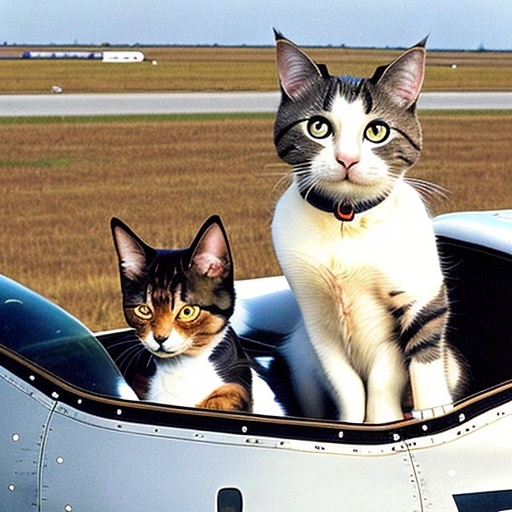

In [2]:
from diffusers import StableDiffusionPipeline
import torch

pipe = StableDiffusionPipeline.from_pretrained(
    "stablediffusionapi/deliberate-v2"
    , torch_dtype=torch.float16
).to("cuda")

prompt = "a photo of a cat and a dog driving an aircraft "*20
image = pipe(
    prompt = prompt
).images[0]
image

In [3]:
prompt = "a photo of a cat and a dog driving an aircraft "*20

In [4]:
tokenizer = pipe.tokenizer
text_encoder = pipe.text_encoder

In [5]:
tokens = tokenizer(
    prompt
    , truncation = False
    , return_tensors = 'pt'
)["input_ids"]
print(len(tokens[0]))

222


In [6]:
embeddings = pipe.text_encoder(
    tokens.to("cuda")
)[0]

RuntimeError: The size of tensor a (222) must match the size of tensor b (77) at non-singleton dimension 1

In [7]:
prompt = "a photo of a cat and a dog driving an aircraft "

In [8]:
tokenizer = pipe.tokenizer
text_encoder = pipe.text_encoder

In [9]:
tokens = tokenizer(
    prompt
    , truncation = False
    , return_tensors = 'pt'
)["input_ids"]
print(len(tokens[0]))

13


In [10]:
embeddings = pipe.text_encoder(
    tokens.to("cuda")
)[0]

In [11]:
tokenizer = pipe.tokenizer
text_encoder = pipe.text_encoder

In [12]:
tokens = tokenizer(
    prompt
    , truncation = False
)["input_ids"]
print("token length:", len(tokens))

token length: 13


In [15]:
from transformers import CLIPTokenizer
neg_prompt = "a bad photo of a cat"

In [16]:
negative_ids = pipe.tokenizer(
    neg_prompt
    , truncation    = False
    , padding       = "max_length"
    , max_length    = len(tokens)
).input_ids
print("neg_token length:", len(negative_ids))

neg_token length: 13


In [17]:
tokens = tokens[1:-1]
negative_ids = negative_ids[1:-1]

In [18]:
embeds,neg_embeds = [],[]
chunk_size = 75
bos = pipe.tokenizer.bos_token_id
eos = pipe.tokenizer.eos_token_id
for i in range(0, len(tokens), chunk_size):
    # Add begin and end token to the 75 chunked tokens to make a 77 token list
    sub_tokens          = [bos] + tokens[i:i + chunk_size] + [eos]

    # text_encoder support torch.Size([1,x]) input tensor
    # that is why use [sub_tokens], instead of simply give sub_tokens.
    tensor_tokens       = torch.tensor(
        [sub_tokens]
        , dtype = torch.long
        , device = pipe.device
    )
    chunk_embeds        = text_encoder(tensor_tokens)[0]
    embeds.append(chunk_embeds)

    # Add begin and end token to the 75 chunked neg tokens to make a 77 token list
    sub_neg_tokens      = [bos] + negative_ids[i:i + chunk_size] + [eos]
    tensor_neg_tokens   = torch.tensor(
        [sub_neg_tokens]
        , dtype = torch.long
        , device = pipe.device
    )
    neg_chunk_embeds    = text_encoder(tensor_neg_tokens)[0]
    neg_embeds.append(neg_chunk_embeds)

In [19]:
prompt_embeds = torch.cat(embeds, dim = 1)
prompt_neg_embeds = torch.cat(neg_embeds, dim = 1)

In [20]:
def long_prompt_encoding(
    pipe:StableDiffusionPipeline
    , prompt
    , neg_prompt = ""
):
    bos = pipe.tokenizer.bos_token_id
    eos = pipe.tokenizer.eos_token_id
    chunk_size = 75

    # step 1. take out the tokenizer and text encoder
    tokenizer = pipe.tokenizer
    text_encoder = pipe.text_encoder

    # step 2.1. encode whatever size prompt to tokens by setting truncation = False.
    tokens = tokenizer(
        prompt
        , truncation = False
        #, return_tensors = 'pt'
    )["input_ids"]

    # step 2.2. encode whatever size neg_prompt, padding it to the size of prompt.
    negative_ids = pipe.tokenizer(
        neg_prompt
        , truncation    = False
        #, return_tensors = "pt"
        , padding       = "max_length"
        , max_length    = len(tokens)
    ).input_ids

    # Step 3. remove begin and end tokens
    tokens = tokens[1:-1]
    negative_ids = negative_ids[1:-1]

    # step 4. Pop out the head 77 tokens, and encode the 77 tokens to embeddings.
    embeds,neg_embeds = [],[]
    for i in range(0, len(tokens), chunk_size):
        # Add begin and end token to the 75 chunked tokens to make a 77 token list
        sub_tokens          = [bos] + tokens[i:i + chunk_size] + [eos]

        # text_encoder support torch.Size([1,x]) input tensor
        # that is why use [sub_tokens], instead of simply give sub_tokens.
        tensor_tokens       = torch.tensor(
            [sub_tokens]
            , dtype = torch.long
            , device = pipe.device
        )
        chunk_embeds        = text_encoder(tensor_tokens)[0]
        embeds.append(chunk_embeds)

        # Add begin and end token to the 75 chunked neg tokens to make a 77 token list
        sub_neg_tokens      = [bos] + negative_ids[i:i + chunk_size] + [eos]
        tensor_neg_tokens   = torch.tensor(
            [sub_neg_tokens]
            , dtype = torch.long
            , device = pipe.device
        )
        neg_chunk_embeds    = text_encoder(tensor_neg_tokens)[0]
        neg_embeds.append(neg_chunk_embeds)

    # step 5. Stack the embeddings to a [1,x,768] size torch tensor.
    prompt_embeds = torch.cat(embeds, dim = 1)
    prompt_neg_embeds = torch.cat(neg_embeds, dim = 1)

    return prompt_embeds, prompt_neg_embeds

torch.Size([1, 84, 768])


  0%|          | 0/50 [00:00<?, ?it/s]

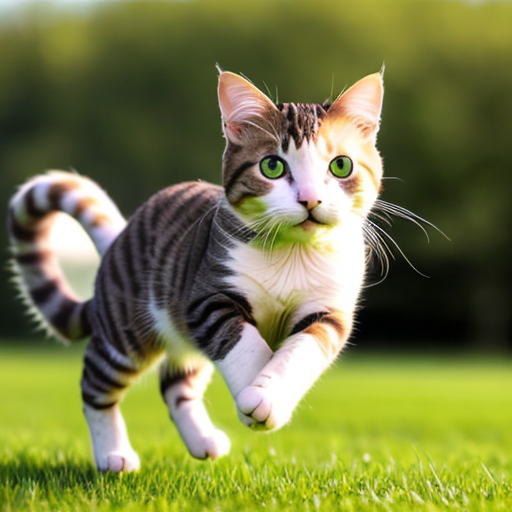

In [21]:
prompt = "photo, cute cat running on the grass" * 10 #<- long prompt
prompt_embeds, prompt_neg_embeds = long_prompt_encoding(
    pipe, prompt, neg_prompt="low resolution, bad anatomy"
)
print(prompt_embeds.shape)

image = pipe(
    prompt_embeds = prompt_embeds
    , negative_prompt_embeds = prompt_neg_embeds
    , generator = torch.Generator("cuda").manual_seed(1)
).images[0]
image

In [22]:
prompt = "photo, cute cat running on the grass" * 10
prompt = prompt + ",pure white cat" * 10

In [23]:
def parse_prompt_attention(text):
    import re
    re_attention = re.compile(
        r"""
            \\\(|\\\)|\\\[|\\]|\\\\|\\|\(|\[|:([+-]?[.\d]+)\)|
            \)|]|[^\\()\[\]:]+|:
        """
        , re.X
    )

    re_break = re.compile(r"\s*\bBREAK\b\s*", re.S)

    res = []
    round_brackets = []
    square_brackets = []

    round_bracket_multiplier = 1.1
    square_bracket_multiplier = 1 / 1.1

    def multiply_range(start_position, multiplier):
        for p in range(start_position, len(res)):
            res[p][1] *= multiplier

    for m in re_attention.finditer(text):
        text = m.group(0)
        weight = m.group(1)

        if text.startswith('\\'):
            res.append([text[1:], 1.0])
        elif text == '(':
            round_brackets.append(len(res))
        elif text == '[':
            square_brackets.append(len(res))
        elif weight is not None and len(round_brackets) > 0:
            multiply_range(round_brackets.pop(), float(weight))
        elif text == ')' and len(round_brackets) > 0:
            multiply_range(round_brackets.pop(), round_bracket_multiplier)
        elif text == ']' and len(square_brackets) > 0:
            multiply_range(square_brackets.pop(), square_bracket_multiplier)
        else:
            parts = re.split(re_break, text)
            for i, part in enumerate(parts):
                if i > 0:
                    res.append(["BREAK", -1])
                res.append([part, 1.0])

    for pos in round_brackets:
        multiply_range(pos, round_bracket_multiplier)

    for pos in square_brackets:
        multiply_range(pos, square_bracket_multiplier)

    if len(res) == 0:
        res = [["", 1.0]]

    # merge runs of identical weights
    i = 0
    while i + 1 < len(res):
        if res[i][1] == res[i + 1][1]:
            res[i][0] += res[i + 1][0]
            res.pop(i + 1)
        else:
            i += 1
    return res

In [24]:
parse_prompt_attention("a (white) cat")

[['a ', 1.0], ['white', 1.1], [' cat', 1.0]]

In [26]:
def get_prompts_tokens_with_weights(
    pipe: StableDiffusionPipeline
    , prompt: str
):
    texts_and_weights = parse_prompt_attention(prompt)
    text_tokens,text_weights = [],[]
    for word, weight in texts_and_weights:
        # tokenize and discard the starting and the ending token
        token = pipe.tokenizer(
            word
            , truncation = False # so that tokenize whatever length prompt
        ).input_ids[1:-1]
        # the returned token is a 1d list: [320, 1125, 539, 320]

        # use merge the new tokens to the all tokens holder: text_tokens
        text_tokens = [*text_tokens,*token]

        # each token chunk will come with one weight, like ['red cat', 2.0]
        # need to expand weight for each token.
        chunk_weights = [weight] * len(token)

        # append the weight back to the weight holder: text_weights
        text_weights = [*text_weights, *chunk_weights]
    return text_tokens,text_weights

In [27]:
prompt = "a (white) cat"
tokens, weights = get_prompts_tokens_with_weights(pipe, prompt)
print(tokens,weights)

[320, 1579, 2368] [1.0, 1.1, 1.0]


In [28]:
# encode "white" only
white_token = 1579
white_token_tensor = torch.tensor(
    [[white_token]]
    , dtype = torch.long
    , device = pipe.device
)
white_embed = pipe.text_encoder(white_token_tensor)[0]
print(white_embed[0][0])

tensor([-3.2617e-01,  1.1871e-02, -5.8502e-02, -1.4795e-01, -4.5013e-02,
        -3.7500e-01, -2.2400e-02, -1.9421e-01,  1.5942e-01, -5.0110e-02,
        -1.9531e-01, -1.4697e-01, -7.6599e-02, -3.2178e-01,  7.5562e-02,
        -1.1133e-01, -1.1163e-01, -7.8796e-02,  6.2012e-02, -2.8078e+01,
        -1.2659e-01, -1.7566e-01, -1.0529e-01, -9.3628e-02, -1.2213e-01,
        -1.0596e-01, -1.6980e-01, -1.9519e-01, -2.7808e-01, -4.4434e-02,
        -4.5441e-02, -9.9670e-02, -9.1248e-02, -7.5195e-02, -2.1191e-01,
        -2.9761e-01, -3.6597e-01, -9.1187e-02, -9.4116e-02,  1.9531e-02,
        -1.7529e-01, -1.4709e-01, -1.8018e-01, -2.1118e-01, -2.1252e-01,
        -2.8394e-01,  2.9327e-02, -1.6309e-01, -3.7695e-01, -1.5173e-01,
         7.4100e-04, -5.5084e-02, -2.5073e-01, -1.0577e-01, -2.7905e-01,
        -3.4082e-01, -2.0798e-02, -1.4307e-01, -3.0347e-01,  9.5520e-02,
         6.5613e-03, -1.0974e-01, -2.0679e-01, -2.2876e-01, -2.6953e-01,
        -2.4841e-01, -3.6572e-01, -2.6245e-01, -1.4

In [29]:
# encode "white cat"
white_token, cat_token = 1579, 2369
white_cat_token_tensor = torch.tensor(
    [[white_token, cat_token]]
    , dtype = torch.long
    , device = pipe.device
)
white_cat_embeds = pipe.text_encoder(white_cat_token_tensor)[0]
print(white_cat_embeds[0][0])

tensor([-3.2617e-01,  1.1871e-02, -5.8502e-02, -1.4795e-01, -4.5013e-02,
        -3.7500e-01, -2.2369e-02, -1.9434e-01,  1.5942e-01, -5.0110e-02,
        -1.9531e-01, -1.4697e-01, -7.6599e-02, -3.2178e-01,  7.5562e-02,
        -1.1139e-01, -1.1163e-01, -7.8796e-02,  6.2073e-02, -2.8078e+01,
        -1.2659e-01, -1.7566e-01, -1.0529e-01, -9.3628e-02, -1.2213e-01,
        -1.0596e-01, -1.6980e-01, -1.9519e-01, -2.7808e-01, -4.4434e-02,
        -4.5441e-02, -9.9609e-02, -9.1248e-02, -7.5195e-02, -2.1191e-01,
        -2.9761e-01, -3.6597e-01, -9.1187e-02, -9.4116e-02,  1.9562e-02,
        -1.7529e-01, -1.4709e-01, -1.8018e-01, -2.1118e-01, -2.1252e-01,
        -2.8394e-01,  2.9343e-02, -1.6309e-01, -3.7695e-01, -1.5173e-01,
         7.4053e-04, -5.5084e-02, -2.5073e-01, -1.0577e-01, -2.7905e-01,
        -3.4082e-01, -2.0828e-02, -1.4307e-01, -3.0347e-01,  9.5520e-02,
         6.5613e-03, -1.0974e-01, -2.0679e-01, -2.2876e-01, -2.6953e-01,
        -2.4841e-01, -3.6572e-01, -2.6245e-01, -1.4

In [30]:
# step 3. padding tokens
def pad_tokens_and_weights(
    token_ids: list
    , weights: list
):
    bos,eos = 49406,49407

    # this will be a 2d list
    new_token_ids = []
    new_weights   = []
    while len(token_ids) >= 75:
        # get the first 75 tokens
        head_75_tokens = [token_ids.pop(0) for _ in range(75)]
        head_75_weights = [weights.pop(0) for _ in range(75)]

        # extract token ids and weights
        temp_77_token_ids = [bos] + head_75_tokens + [eos]
        temp_77_weights   = [1.0] + head_75_weights + [1.0]

        # add 77 token and weights chunk to the holder list
        new_token_ids.append(temp_77_token_ids)
        new_weights.append(temp_77_weights)

    # padding the left
    if len(token_ids) > 0:
        padding_len         = 75 - len(token_ids)
        padding_len = 0

        temp_77_token_ids   = [bos] + token_ids + [eos] * padding_len + [eos]
        new_token_ids.append(temp_77_token_ids)

        temp_77_weights     = [1.0] + weights   + [1.0] * padding_len + [1.0]
        new_weights.append(temp_77_weights)

    # return
    return new_token_ids, new_weights

In [31]:
t,w = pad_tokens_and_weights(tokens.copy(), weights.copy())
print(t)
print(w)

[[49406, 320, 1579, 2368, 49407]]
[[1.0, 1.0, 1.1, 1.0, 1.0]]


In [32]:
def get_weighted_text_embeddings(
    pipe: StableDiffusionPipeline
    , prompt : str      = ""
    , neg_prompt: str   = ""
):
    eos = pipe.tokenizer.eos_token_id
    prompt_tokens, prompt_weights = get_prompts_tokens_with_weights(
        pipe, prompt
    )
    neg_prompt_tokens, neg_prompt_weights = get_prompts_tokens_with_weights(
        pipe, neg_prompt
    )

    # padding the shorter one
    prompt_token_len        = len(prompt_tokens)
    neg_prompt_token_len    = len(neg_prompt_tokens)
    if prompt_token_len > neg_prompt_token_len:
        # padding the neg_prompt with eos token
        neg_prompt_tokens   = (
            neg_prompt_tokens  +
            [eos] * abs(prompt_token_len - neg_prompt_token_len)
        )
        neg_prompt_weights  = (
            neg_prompt_weights +
            [1.0] * abs(prompt_token_len - neg_prompt_token_len)
        )
    else:
        # padding the prompt
        prompt_tokens       = (
            prompt_tokens
            + [eos] * abs(prompt_token_len - neg_prompt_token_len)
        )
        prompt_weights      = (
            prompt_weights
            + [1.0] * abs(prompt_token_len - neg_prompt_token_len)
        )

    embeds = []
    neg_embeds = []

    prompt_token_groups ,prompt_weight_groups = pad_tokens_and_weights(
        prompt_tokens.copy()
        , prompt_weights.copy()
    )

    neg_prompt_token_groups, neg_prompt_weight_groups = pad_tokens_and_weights(
        neg_prompt_tokens.copy()
        , neg_prompt_weights.copy()
    )

    # get prompt embeddings one by one is not working.
    for i in range(len(prompt_token_groups)):
        # get positive prompt embeddings with weights
        token_tensor = torch.tensor(
            [prompt_token_groups[i]]
            ,dtype = torch.long, device = pipe.device
        )
        weight_tensor = torch.tensor(
            prompt_weight_groups[i]
            , dtype     = torch.float16
            , device    = pipe.device
        )
        token_embedding = pipe.text_encoder(token_tensor)[0].squeeze(0)
        for j in range(len(weight_tensor)):
            token_embedding[j] = token_embedding[j] * weight_tensor[j]
        token_embedding = token_embedding.unsqueeze(0)
        embeds.append(token_embedding)

        # get negative prompt embeddings with weights
        neg_token_tensor = torch.tensor(
            [neg_prompt_token_groups[i]]
            , dtype = torch.long, device = pipe.device
        )
        neg_weight_tensor = torch.tensor(
            neg_prompt_weight_groups[i]
            , dtype     = torch.float16
            , device    = pipe.device
        )
        neg_token_embedding = pipe.text_encoder(neg_token_tensor)[0].squeeze(0)
        for z in range(len(neg_weight_tensor)):
            neg_token_embedding[z] = (
                neg_token_embedding[z] * neg_weight_tensor[z]
            )
        neg_token_embedding = neg_token_embedding.unsqueeze(0)
        neg_embeds.append(neg_token_embedding)

    prompt_embeds       = torch.cat(embeds, dim = 1)
    neg_prompt_embeds   = torch.cat(neg_embeds, dim = 1)

    return prompt_embeds, neg_prompt_embeds

  0%|          | 0/50 [00:00<?, ?it/s]

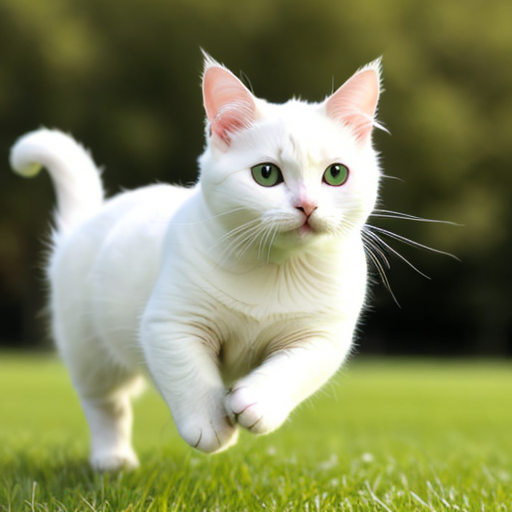

In [33]:
prompt = "photo, cute cat running on the grass" * 10
prompt = prompt + ",pure (white:1.5) cat" * 10

neg_prompt = "low resolution, bad anatomy"

prompt_embeds, prompt_neg_embeds = get_weighted_text_embeddings(pipe, prompt = prompt, neg_prompt = neg_prompt)

image = pipe(
    prompt_embeds = prompt_embeds
    , negative_prompt_embeds = prompt_neg_embeds
    , generator = torch.Generator("cuda").manual_seed(1)
).images[0]
image

In [34]:
from diffusers import DiffusionPipeline
import torch

model_id_or_path = "stablediffusionapi/deliberate-v2"
pipe = DiffusionPipeline.from_pretrained(
    model_id_or_path
    , torch_dtype       = torch.float16
    , custom_pipeline   = "lpw_stable_diffusion"
).to("cuda:0")

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:655: FutureWarning: 'cached_download' is the legacy way to download files from the HF hub, please consider upgrading to 'hf_hub_download'
  warnings.warn(


(…)amples/community/lpw_stable_diffusion.py:   0%|          | 0.00/12.7k [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


Token indices sequence length is longer than the specified maximum sequence length for this model (84 > 77). Running this sequence through the model will result in indexing errors


  0%|          | 0/50 [00:00<?, ?it/s]

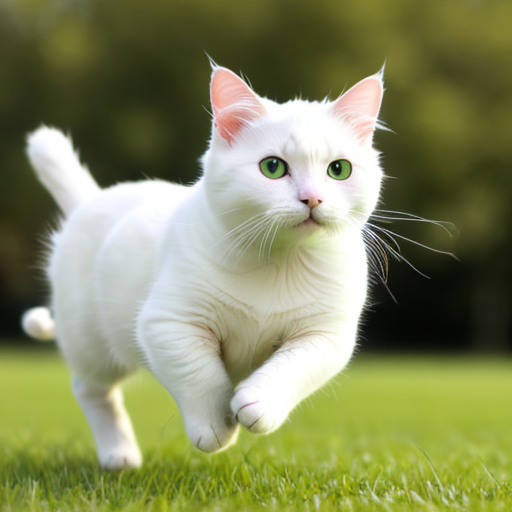

In [35]:
prompt = "photo, cute cat running on the grass" * 10
prompt = prompt + ",pure (white:1.5) cat" * 10

neg_prompt = "low resolution, bad anatomy"
image = pipe(
    prompt = prompt
    , negative_prompt = neg_prompt
    , generator = torch.Generator("cuda").manual_seed(1)
).images[0]
image

In [37]:
!pip install accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.1/290.1 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 69.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 89.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

In [2]:
from diffusers import DiffusionPipeline
import torch

model_id_or_path = "stabilityai/stable-diffusion-xl-base-1.0"
pipe = DiffusionPipeline.from_pretrained(
    model_id_or_path
    , torch_dtype       = torch.float16
    , custom_pipeline   = "lpw_stable_diffusion_xl",
).to("cuda:0")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:655: FutureWarning: 'cached_download' is the legacy way to download files from the HF hub, please consider upgrading to 'hf_hub_download'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:655: FutureWarning: 'cached_download' is the legacy way to download files from the HF hub, please consider upgrading to 'hf_hub_download'
  warnings.warn(


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (84 > 77). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (84 > 77). Running this sequence through the model will result in indexing errors


  0%|          | 0/50 [00:00<?, ?it/s]

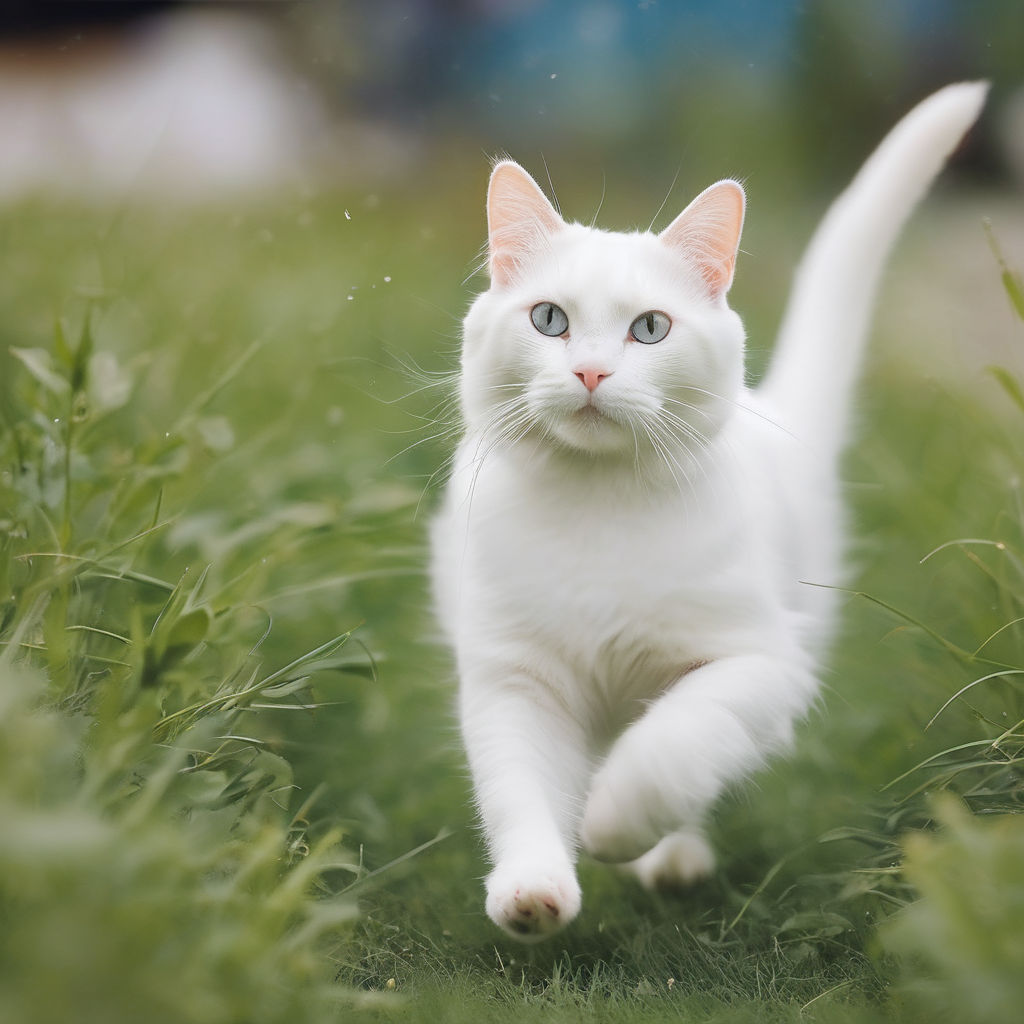

In [3]:
prompt = "photo, cute cat running on the grass" * 10
prompt = prompt + ",pure (white:1.5) cat" * 10

neg_prompt = "low resolution, bad anatomy"
image = pipe(
    prompt = prompt
    , negative_prompt = neg_prompt
    , generator = torch.Generator("cuda").manual_seed(7)
).images[0]
image